In [1]:
import sys
sys.path.append('/nfs/xwx/model-doctor-xwx')

import torch
import torchvision
import models
import loaders
import argparse
import os
import datetime
import time
import matplotlib
import yaml
import math


from torch import optim
from configs import config
from utils.lr_util import get_lr_scheduler
from utils.time_util import print_time, get_current_time
from sklearn.metrics import classification_report
from loss.refl import reduce_equalized_focal_loss
from loss.fl import focal_loss
from loss.hcl import hc_loss
from modify_kernel.util.draw_util import draw_lr, draw_fc_weight
from modify_kernel.util.cfg_util import print_yml_cfg
from functools import partial
from utils.args_util import print_args
from utils.general import init_seeds, get_head_and_kernel, get_head_ratio

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import warnings # ignore warnings
warnings.filterwarnings("ignore")


In [2]:
model_name = "resnet32"
# model_path = "/nfs/xwx/model-doctor-xwx/output/model/pretrained/resnet32/cifar-100-lt-ir100/lr0.1/custom_lr_scheduler/ce_loss/2022-07-01_04-04-08/best-model-acc0.3912.pth"
# model_path = "/nfs/xwx/model-doctor-xwx/output/model/pretrained/resnet32/cifar-100-lt-ir10/lr0.1/custom_lr_scheduler/ce_loss/2022-07-06_21-16-55/best-model-acc0.5810.pth"
# model_path = "/nfs/xwx/model-doctor-xwx/output/model/pretrained/resnet32/cifar-10-lt-ir100/lr0.1/custom_lr_scheduler/bsl_loss/2022-07-14_21-13-14/best-model-acc0.8245.pth"
model_path = "/mnt/nfs/xwx/model-doctor-xwx/output/model/pretrained/resnet32/cifar-10-lt-ir100/lr0.01/cosine_lr_scheduler/ce_loss/2022-07-15_17-27-58/best-model-acc0.7144.pth"
data_name  = "cifar-10-lt-ir100"

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
data_loaders, _ = loaders.load_data(data_name=data_name)

----------------------------------------
LOAD DATA: cifar-10-lt-ir100
----------------------------------------
load cifar dataset from image dir

load cifar dataset from image dir



In [5]:
base_model = models.load_model(
    model_name=model_name, 
    in_channels=3,
    num_classes=10
)

base_model.load_state_dict(torch.load(model_path)["model"])
base_model.to(device);

----------------------------------------
LOAD MODEL: resnet32
----------------------------------------


In [6]:
def test(dataloader, model, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)
        pred, _ = model(X)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    correct /= size
        
    print(f"Test Error: Accuracy: {(100*correct):>0.2f}%")

In [7]:
test(data_loaders["val"], base_model, device)

Test Error: Accuracy: 71.44%


In [8]:
import copy

model = copy.deepcopy(base_model)

In [ ]:
def draw_fc_weight(fc_weight):
    fc_weight = np.sum(fc_weight * fc_weight, axis=1)
    fc_weight = fc_weight**0.5

    plt.plot(range(len(fc_weight)), fc_weight, 'r', label='fc weight')
    
    plt.title("fc weight")
    plt.xlabel("class")
    plt.ylabel("l2 weight")
    plt.legend(loc="upper right")
    plt.grid(True)

In [9]:
def plot_norms(W, y_range=None):
    # per-class weight norms vs. class cardinality
    tmp = torch.linalg.norm(W, ord=2, dim=1).detach().numpy()
    
    if y_range==None:
        max_val, mid_val, min_val = tmp.max(), tmp.mean(), tmp.min()
        c = min(1/mid_val, mid_val)
        y_range = [min_val-c, max_val+c]
    
    
    fig = plt.figure(figsize=(15,3), dpi=64, facecolor='w', edgecolor='k')
    plt.xticks(list(range(100)), rotation=90, fontsize=8);  # Set text labels.
    ax1 = fig.add_subplot(111)

    ax1.set_ylabel('norm', fontsize=16)
    ax1.set_ylim(y_range)
    
    plt.plot(tmp, linewidth=2)
    plt.title('norms of per-class weights from the learned classifier vs. class cardinality', fontsize=20)

In [10]:
fc_weight = base_model.linear.weight.detach().cpu().numpy()
    
# draw_fc_weight(fc_weight)

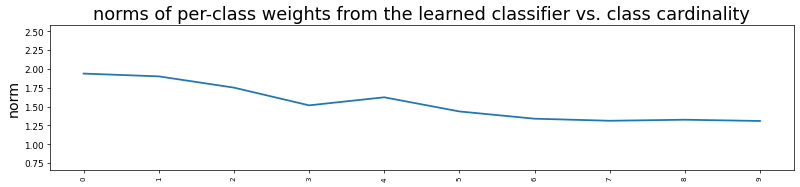

In [28]:
plot_norms(base_model.linear.weight.detach().cpu())

In [ ]:
class Normalizer(): 
    def __init__(self, LpNorm=2, tau = 1):
        self.LpNorm = LpNorm
        self.tau = tau
  
    def apply_on(self, model): #this method applies tau-normalization on the classifier layer

        for curLayer in [model.linear.weight]: #change to last layer: Done
            curparam = curLayer.data

            curparam_vec = curparam.reshape((curparam.shape[0], -1))
            neuronNorm_curparam = (torch.linalg.norm(curparam_vec, ord=self.LpNorm, dim=1)**self.tau).detach().unsqueeze(-1)
            scalingVect = torch.ones_like(curparam)    
            
            idx = neuronNorm_curparam == neuronNorm_curparam
            idx = idx.squeeze()
            tmp = 1 / (neuronNorm_curparam[idx].squeeze())
            for _ in range(len(scalingVect.shape)-1):
                tmp = tmp.unsqueeze(-1)

            scalingVect[idx] = torch.mul(scalingVect[idx], tmp)
            curparam[idx] = scalingVect[idx] * curparam[idx]

In [ ]:
import copy

L2_norm_model = copy.deepcopy(base_model)
L2_norm = Normalizer(tau=1)
L2_norm.apply_on(L2_norm_model)

test(data_loaders["val"], L2_norm_model, device)

In [ ]:
plot_norms(L2_norm_model.linear.weight.detach().cpu())

In [ ]:
taus = [0.1*i for i in range(1, 21, 1)]

for tau in taus:
    print(f"tau: {tau:.1f}, ",end="")
    tau_norm_model = copy.deepcopy(base_model)
    tau_norm = Normalizer(tau=tau)
    tau_norm.apply_on(tau_norm_model)


    test(data_loaders["val"], tau_norm_model, device)

In [ ]:
plot_norms(tau_norm_model.linear.weight.detach().cpu())

In [ ]:
L2_norm_model = copy.deepcopy(base_model)
fc_weight = L2_norm_model.linear.weight
L2_norm_model.linear.weight.data = fc_weight / torch.norm(fc_weight, 2, 1, keepdim=True)

test(data_loaders["val"], L2_norm_model, device)

In [12]:
def train(dataloader, model, loss_fn, optimizer, device):
    train_loss, correct = 0, 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        with torch.set_grad_enabled(True):
            pred, _ = model(X)  # 网络前向计算

            loss = loss_fn(pred, y)
            train_loss += loss.item()
            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Backpropagation
            optimizer.zero_grad()  # 清除过往梯度
            loss.backward()  # 得到模型中参数对当前输入的梯度
            optimizer.step()  # 更新参数
    
    train_loss /= num_batches
    correct /= size
    
    print(f"Train Error: Accuracy: {(100*correct):>0.2f}%, Avg loss: {train_loss:>8f}")
    

Test Error: Accuracy: 72.31%


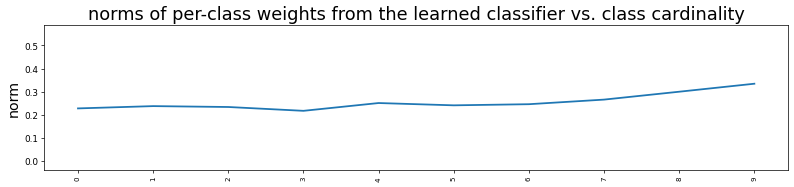

In [37]:
import math
import copy

model = copy.deepcopy(base_model)
s = [5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]
s = torch.tensor(s).to(device)
s = torch.diag_embed(s)
# model.linear.weight.data[:5] = model.linear.weight.data[:5]
# print(model.linear.weight.data.shape)
model.linear.weight.data = 1/s.log() @ model.linear.weight.data
# print(model.linear.weight.data.shape)

plot_norms(model.linear.weight.detach().cpu())
test(data_loaders["val"], model, device)

In [30]:

# 随机化FC层参数
# fc_weight = model.linear.weight
# stdv = 1. / math.sqrt(fc_weight.size(1))
# model.linear.weight.data.uniform_(-stdv, stdv)


# fc_weight = model.linear.weight
# 随机化分类头的值重新训练
# stdv = 1. / math.sqrt(fc_weight.size(1))
# model.linear.weight.data.uniform_(-stdv, stdv)
# model.linear.weight.data = fc_weight / torch.norm(fc_weight, 2, 1, keepdim=True)

active_layers = [model.linear.weight, model.linear.bias]  # 只调整分类头
# active_layers = [model.layer3[4].conv2.weight, model.linear.weight, model.linear.bias]

for param in model.parameters(): #freez all model paramters except the classifier layer
    param.requires_grad = False
    
for param in active_layers:
    param.requires_grad = True

base_lr = 0.01
total_epoch_num = 10
weight_decay = 2e-3 #weight decay value

optimizer = optim.SGD([{'params': active_layers, 'lr': base_lr}], lr=base_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, total_epoch_num, eta_min=0.0)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(total_epoch_num):
    print(f"\nEpoch {epoch+1}")
    train(data_loaders["train"], model, loss_fn, optimizer, device)
    test(data_loaders["val"], model, device)
    scheduler.step()


Epoch 1
Train Error: Accuracy: 95.31%, Avg loss: 0.223971
Test Error: Accuracy: 63.12%

Epoch 2
Train Error: Accuracy: 97.69%, Avg loss: 0.096434
Test Error: Accuracy: 64.06%

Epoch 3
Train Error: Accuracy: 97.90%, Avg loss: 0.080992
Test Error: Accuracy: 65.76%

Epoch 4
Train Error: Accuracy: 98.05%, Avg loss: 0.073833
Test Error: Accuracy: 65.61%

Epoch 5
Train Error: Accuracy: 98.11%, Avg loss: 0.073877
Test Error: Accuracy: 66.16%

Epoch 6
Train Error: Accuracy: 97.98%, Avg loss: 0.075447
Test Error: Accuracy: 65.94%

Epoch 7
Train Error: Accuracy: 97.67%, Avg loss: 0.074071
Test Error: Accuracy: 66.33%

Epoch 8
Train Error: Accuracy: 98.19%, Avg loss: 0.067060
Test Error: Accuracy: 66.36%

Epoch 9
Train Error: Accuracy: 98.25%, Avg loss: 0.068383
Test Error: Accuracy: 66.22%

Epoch 10
Train Error: Accuracy: 97.94%, Avg loss: 0.070211
Test Error: Accuracy: 65.70%
